In [1]:
import pandas as pd
import numpy as np
import ast

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
ia_A_path = "full/ia_A.csv"
df_A = pd.read_csv(ia_A_path)

In [3]:
article_col='article_id'
difficulty_col='difficulty_level'
batch_col='article_batch'
paragraph_col='paragraph_id'

df_A['text_id'] = (
    df_A[article_col].astype(str) + '_' +
    df_A[difficulty_col].astype(str) + '_' +
    df_A[batch_col].astype(str) + '_' +
    df_A[paragraph_col].astype(str)
)

In [4]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True]
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False]

In [5]:
def create_correct_answer(df):
    df = df.copy()
    df['is_correct'] = (df['selected_answer_position'] == df['correct_answer_position']).astype(int)
    return df

In [6]:
def create_area_screen_loc(df):
    df = df.copy()
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['1_tokens'] = df['answer_1'].str.split()
    df['2_tokens'] = df['answer_2'].str.split()
    df['3_tokens'] = df['answer_3'].str.split()
    df['4_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['1_len'] = df['1_tokens'].apply(len)
    df['2_len'] = df['2_tokens'].apply(len)
    df['3_len'] = df['3_tokens'].apply(len)
    df['4_len'] = df['4_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        first_len = group['1_len'].iloc[0]
        second_len = group['2_len'].iloc[0]
        third_len = group['3_len'].iloc[0]
        fourth_len = group['4_len'].iloc[0]

        q_end = q_len - 1
        first_end = q_len + first_len - 1
        second_end = q_len + first_len + second_len - 1
        third_end = q_len + first_len + second_len + third_len - 1
        fourth_end = q_len + first_len + second_len + third_len + fourth_len

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= first_end),
            (index_id > first_end) & (index_id <= second_end),
            (index_id > second_end) & (index_id <= third_end),
            (index_id > third_end) & (index_id <= fourth_end)
        ]

        choices = ['question', 'answer_0', 'answer_1', 'answer_2', 'answer_3']
        group['area_screen_loc'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [7]:
def create_area_label(df):
    def get_screen_loc(row):
        if row['area_screen_loc'] == 'question':
            return 'question'
        elif row['area_screen_loc'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            idx = int(row['area_screen_loc'].split('_')[1])
            return f'answer_{answers_order[idx]}'
        return None

    df['area_label'] = df.apply(get_screen_loc, axis=1)
    return df

In [8]:
def create_selected_answer_label(df):
    df = df.copy()
    df['answers_order'] = df['answers_order'].apply(ast.literal_eval)
    df['selected_answer_label'] = df.apply(lambda row: row['answers_order'][row['selected_answer_position']], axis=1)
    return df

In [9]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_correct_answer,
    create_area_screen_loc,
    create_area_label,
    create_selected_answer_label,
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

<function create_correct_answer at 0x000001F1EA1F1090>
<function create_area_screen_loc at 0x000001F1A859A3B0>
<function create_area_label at 0x000001F1EA1F1630>
<function create_selected_answer_label at 0x000001F1EA1F11B0>
<function create_correct_answer at 0x000001F1EA1F1090>
<function create_area_screen_loc at 0x000001F1A859A3B0>
<function create_area_label at 0x000001F1EA1F1630>
<function create_selected_answer_label at 0x000001F1EA1F11B0>


In [10]:
def create_fixation_sequence_tags_no_unknowns(df):
    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        group_ids = set(group['IA_ID'].unique())

        id_to_label = dict(zip(group['IA_ID'], group['area_label']))
        id_to_location = dict(zip(group['IA_ID'], group['area_screen_loc']))

        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)

        label_sequence = []
        location_sequence = []

        for ia_id in sequence:
            if ia_id in group_ids:
                label_sequence.append(id_to_label[ia_id])
                location_sequence.append(id_to_location[ia_id])
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'fix_by_label_clean': label_sequence,
            'fix_by_loc_clean': location_sequence
        })

    return pd.DataFrame(result)


In [11]:
def create_simplified_fixation_tags(df):
    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        group_ids = set(group['IA_ID'].unique())

        id_to_label = dict(zip(group['IA_ID'], group['area_label']))
        id_to_location = dict(zip(group['IA_ID'], group['area_screen_loc']))

        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)

        simplified_labels = []
        simplified_locations = []

        for ia_id in sequence:
            if ia_id not in group_ids:
                continue
            label = id_to_label[ia_id]
            location = id_to_location[ia_id]
            if not simplified_labels or simplified_labels[-1] != label:
                simplified_labels.append(label)
                simplified_locations.append(location)

        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'simpl_fix_by_label': simplified_labels[1:],
            'simpl_fix_by_loc': simplified_locations[1:]
        })

    return pd.DataFrame(result)

In [12]:
def generate_new_row_features(functions, df, default_join_columns=['TRIAL_INDEX', 'participant_id', 'area_label']):
    result_df = df.copy()

    for func_tuple in functions:
        func, func_kwargs = func_tuple
        print(func)

        join_columns = func_kwargs.get('join_columns', default_join_columns)

        new_features_df = func(df)
        result_df = result_df.merge(new_features_df, on=join_columns, how='left')

    return result_df

In [13]:
per_row_feature_generators = [
    (create_fixation_sequence_tags_no_unknowns, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (create_simplified_fixation_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
]

df_with_features_h = generate_new_row_features(per_row_feature_generators, df_base_features_h)
df_with_features_g = generate_new_row_features(per_row_feature_generators, df_base_features_g)

<function create_fixation_sequence_tags_no_unknowns at 0x000001F44D044160>
<function create_simplified_fixation_tags at 0x000001F44D047520>
<function create_fixation_sequence_tags_no_unknowns at 0x000001F44D044160>
<function create_simplified_fixation_tags at 0x000001F44D047520>


In [14]:
categories_label = {
    "question": "#74a9cf",
    "answer_A": "#238b45",
    "answer_B": "#74c476",
    "answer_C": "#bae4b3",
    "answer_D": "#edf8e9",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "white"
}

categories_loc = {
    "question": "#74a9cf",
    'answer_0': "#ffffb2",
    'answer_1': "#fecc5c",
    'answer_2': "#fd8d3c",
    'answer_3': "#e31a1c",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "white"
}

legend_mapping_label = {
    "question": "Question",
    "answer_A": "Answer A",
    "answer_B": "Answer B",
    "answer_C": "Answer C",
    "answer_D": "Answer D",
    "out_of_bounds": "Unclear",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}

legend_mapping_loc = {
    "out_of_bounds": "Unclear",
    "question": "Question",
    "answer_0": "First Answer on screen",
    "answer_1": "Second Answer on screen",
    "answer_2": "Third Answer on screen",
    "answer_3": "Fourth Answer on screen",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}

In [15]:
def visualize_stacked_rows_with_two_labels(data_rows, categories, selected_answer_labels, additional_labels, num_rows=100, start_index=0, legend_mapping=None):
    selected_rows = data_rows[start_index:start_index + num_rows]
    selected_labels = selected_answer_labels[start_index:start_index + num_rows]
    additional_labels = additional_labels[start_index:start_index + num_rows]


    max_length = max(len(row) for row in selected_rows) + 2  # +2 to account for the labels

    color_data = []
    for row in selected_rows:
        color_row = [categories.get(value, "gray") for value in row] + ["white"] * (max_length - len(row))
        color_data.append(color_row)

    plt.figure(figsize=(15, num_rows * 0.3))
    for i, (color_row, label, additional_label) in enumerate(zip(color_data, selected_labels, additional_labels)):
        plt.bar(range(max_length), [1] * max_length, color=color_row, width=1.0, edgecolor='none', bottom=i)
        plt.text(-3.5, i + 0.5, str(additional_label), va='center', ha='right', fontsize=10, color=categories.get(additional_label, "black"))
        plt.text(-1.5, i + 0.5, str(label), va='center', ha='right', fontsize=10, color=categories.get(label, "black"))

    plt.axis('off')

    if legend_mapping:
        legend_handles = [
            mpatches.Patch(color=categories.get(original_label, "gray"), label=new_label)
            for original_label, new_label in legend_mapping.items()
            if new_label is not None
        ]
    else:
        legend_handles = [
            mpatches.Patch(color=color, label=str(label)) for label, color in categories.items()
        ]

    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

    plt.tight_layout()
    plt.show()

In [16]:
df_with_features_h['fix_by_label_clean'] = df_with_features_h['fix_by_label_clean'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_label_clean'] = df_with_features_g['fix_by_label_clean'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_h['fix_by_loc_clean'] = df_with_features_h['fix_by_loc_clean'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_loc_clean'] = df_with_features_g['fix_by_loc_clean'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

data_rows_h = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'text_id', 'fix_by_label_clean', 'fix_by_loc_clean','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()
data_rows_g = df_with_features_g[['TRIAL_INDEX', 'participant_id', 'text_id', 'fix_by_label_clean', 'fix_by_loc_clean','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()

In [17]:
# df_with_features_h['simpl_fix_by_label'] = df_with_features_h['simpl_fix_by_label'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
# df_with_features_g['simpl_fix_by_label'] = df_with_features_g['simpl_fix_by_label'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
# df_with_features_h['simpl_fix_by_loc'] = df_with_features_h['simpl_fix_by_loc'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
# df_with_features_g['simpl_fix_by_loc'] = df_with_features_g['simpl_fix_by_loc'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
#
# data_rows_h = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'text_id', 'simpl_fix_by_label', 'simpl_fix_by_loc','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()
# data_rows_g = df_with_features_g[['TRIAL_INDEX', 'participant_id', 'text_id', 'simpl_fix_by_label', 'simpl_fix_by_loc','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()

In [18]:
import random

def visualize_by_id(data, by_person_or_text, fix_by, identifier=None):
    if by_person_or_text not in ['person', 'text']:
        raise ValueError("The 'by_person_or_text' parameter must be either 'person' or 'text'.")

    if fix_by not in ['label', 'loc']:
        raise ValueError("The 'fix_by' parameter must be either 'label' or 'loc'.")

    if fix_by == 'label':
        categories = categories_label
        legend_mapping = legend_mapping_label
        data_column = 'fix_by_label_clean'
        #data_column = 'simpl_fix_by_label'

    else:  # fix_by == 'loc'
        categories = categories_loc
        legend_mapping = legend_mapping_loc
        data_column = 'fix_by_loc_clean'
        #data_column = 'simpl_fix_by_loc'

    filter_column = 'participant_id' if by_person_or_text == 'person' else 'text_id'

    if identifier is None:
        available_ids = data[filter_column].dropna().unique()
        if len(available_ids) == 0:
            raise ValueError(f"No valid entries found in column '{filter_column}'.")
        identifier = random.choice(available_ids)
        print(f"Randomly selected {filter_column}: {identifier}")

    subset = data[data[filter_column] == identifier]
    if subset.empty:
        print(f"No data found for {filter_column} = {identifier}.")
        return

    try:
        fix_data_rows = subset[data_column].tolist()
    except KeyError:
        raise KeyError(f"Column '{data_column}' not found in the data.")

    selected_answer_labels = subset['selected_answer_label'].tolist()
    additional_labels = subset['correct_answer_position'].tolist()

    visualize_stacked_rows_with_two_labels(
        fix_data_rows, categories, selected_answer_labels, additional_labels,
        num_rows=len(fix_data_rows), legend_mapping=legend_mapping
    )



Randomly selected participant_id: l31_62


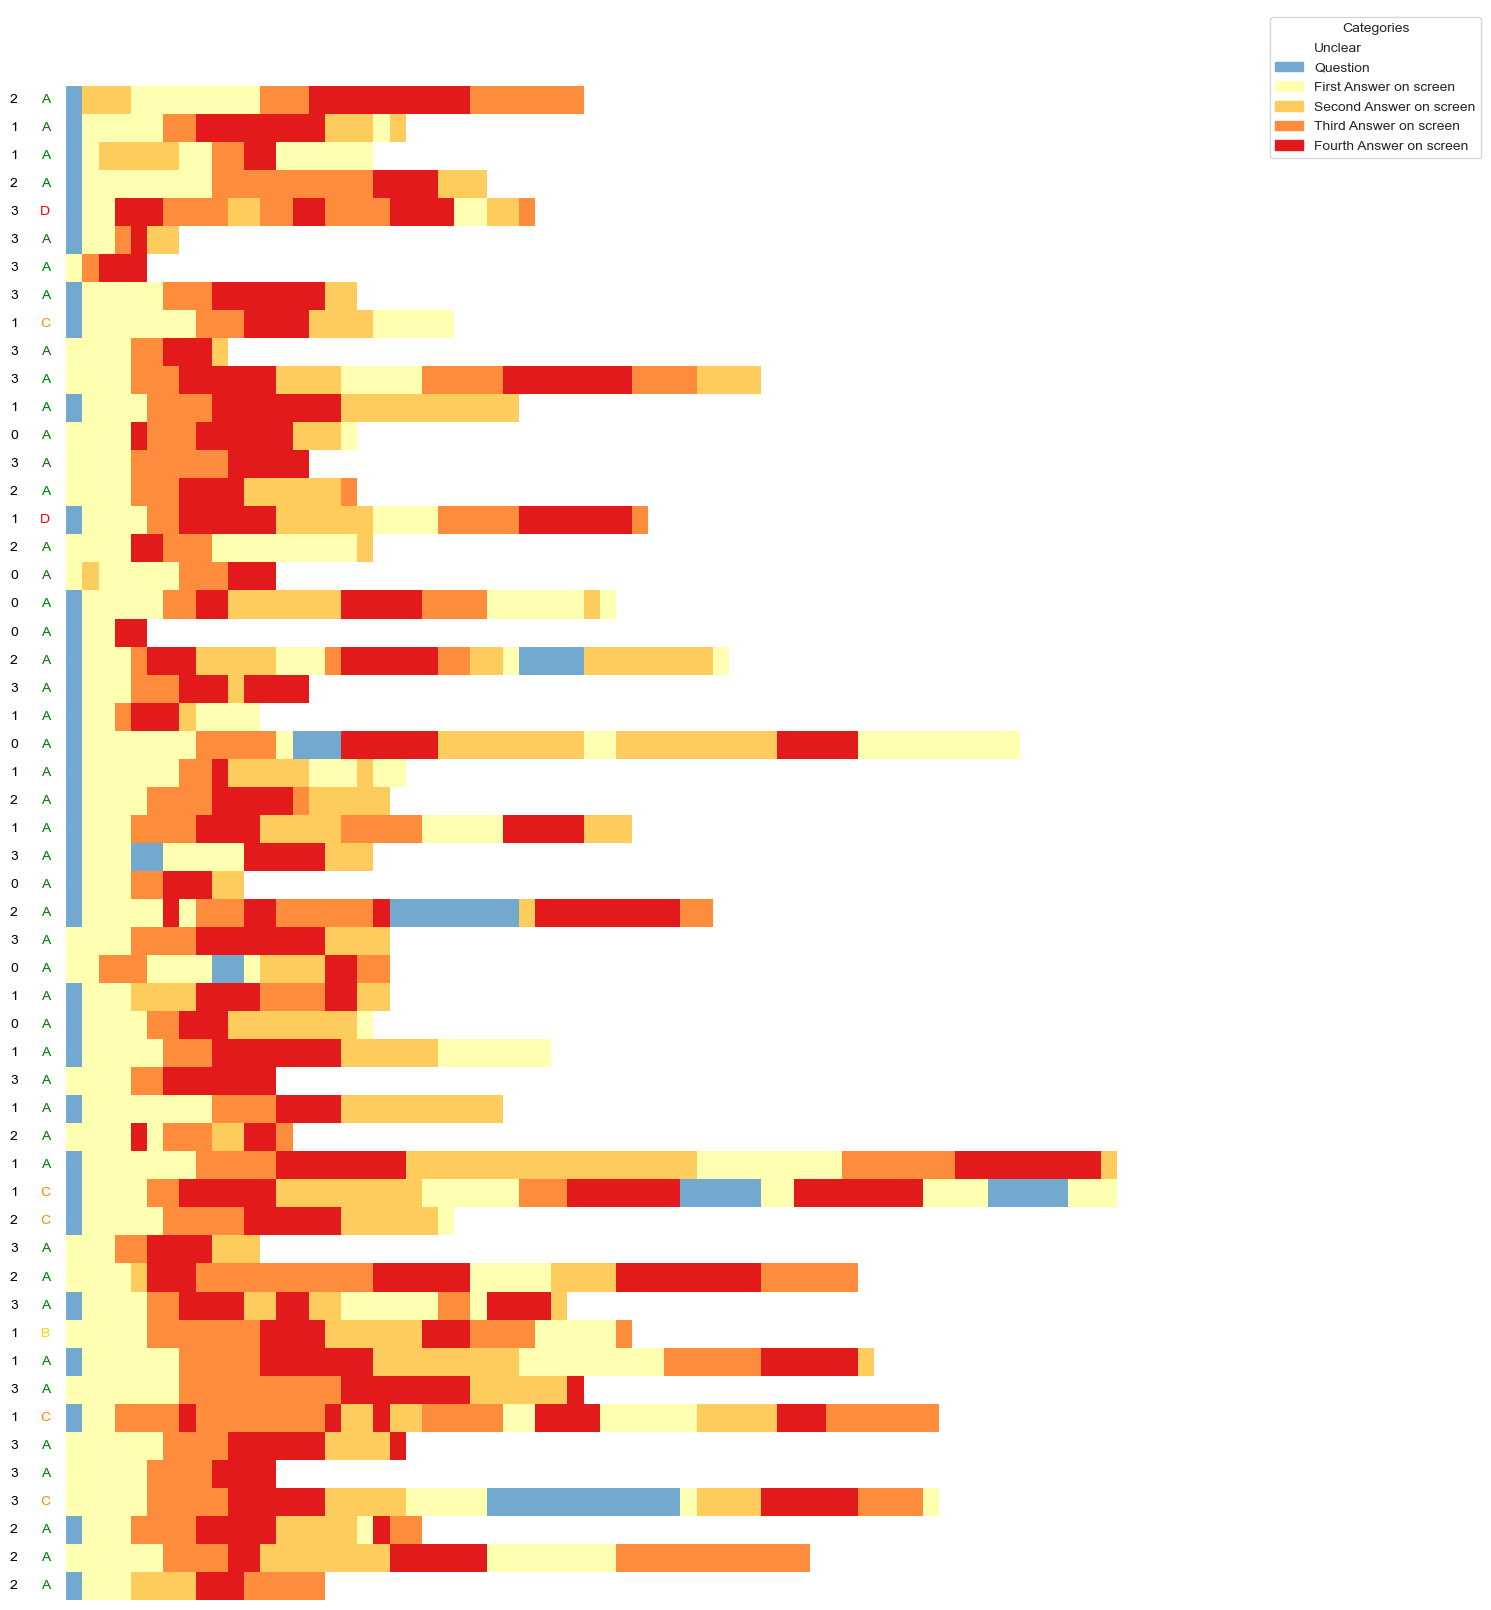

In [19]:
visualize_by_id(data_rows_h, by_person_or_text='person', fix_by='loc', identifier=None)

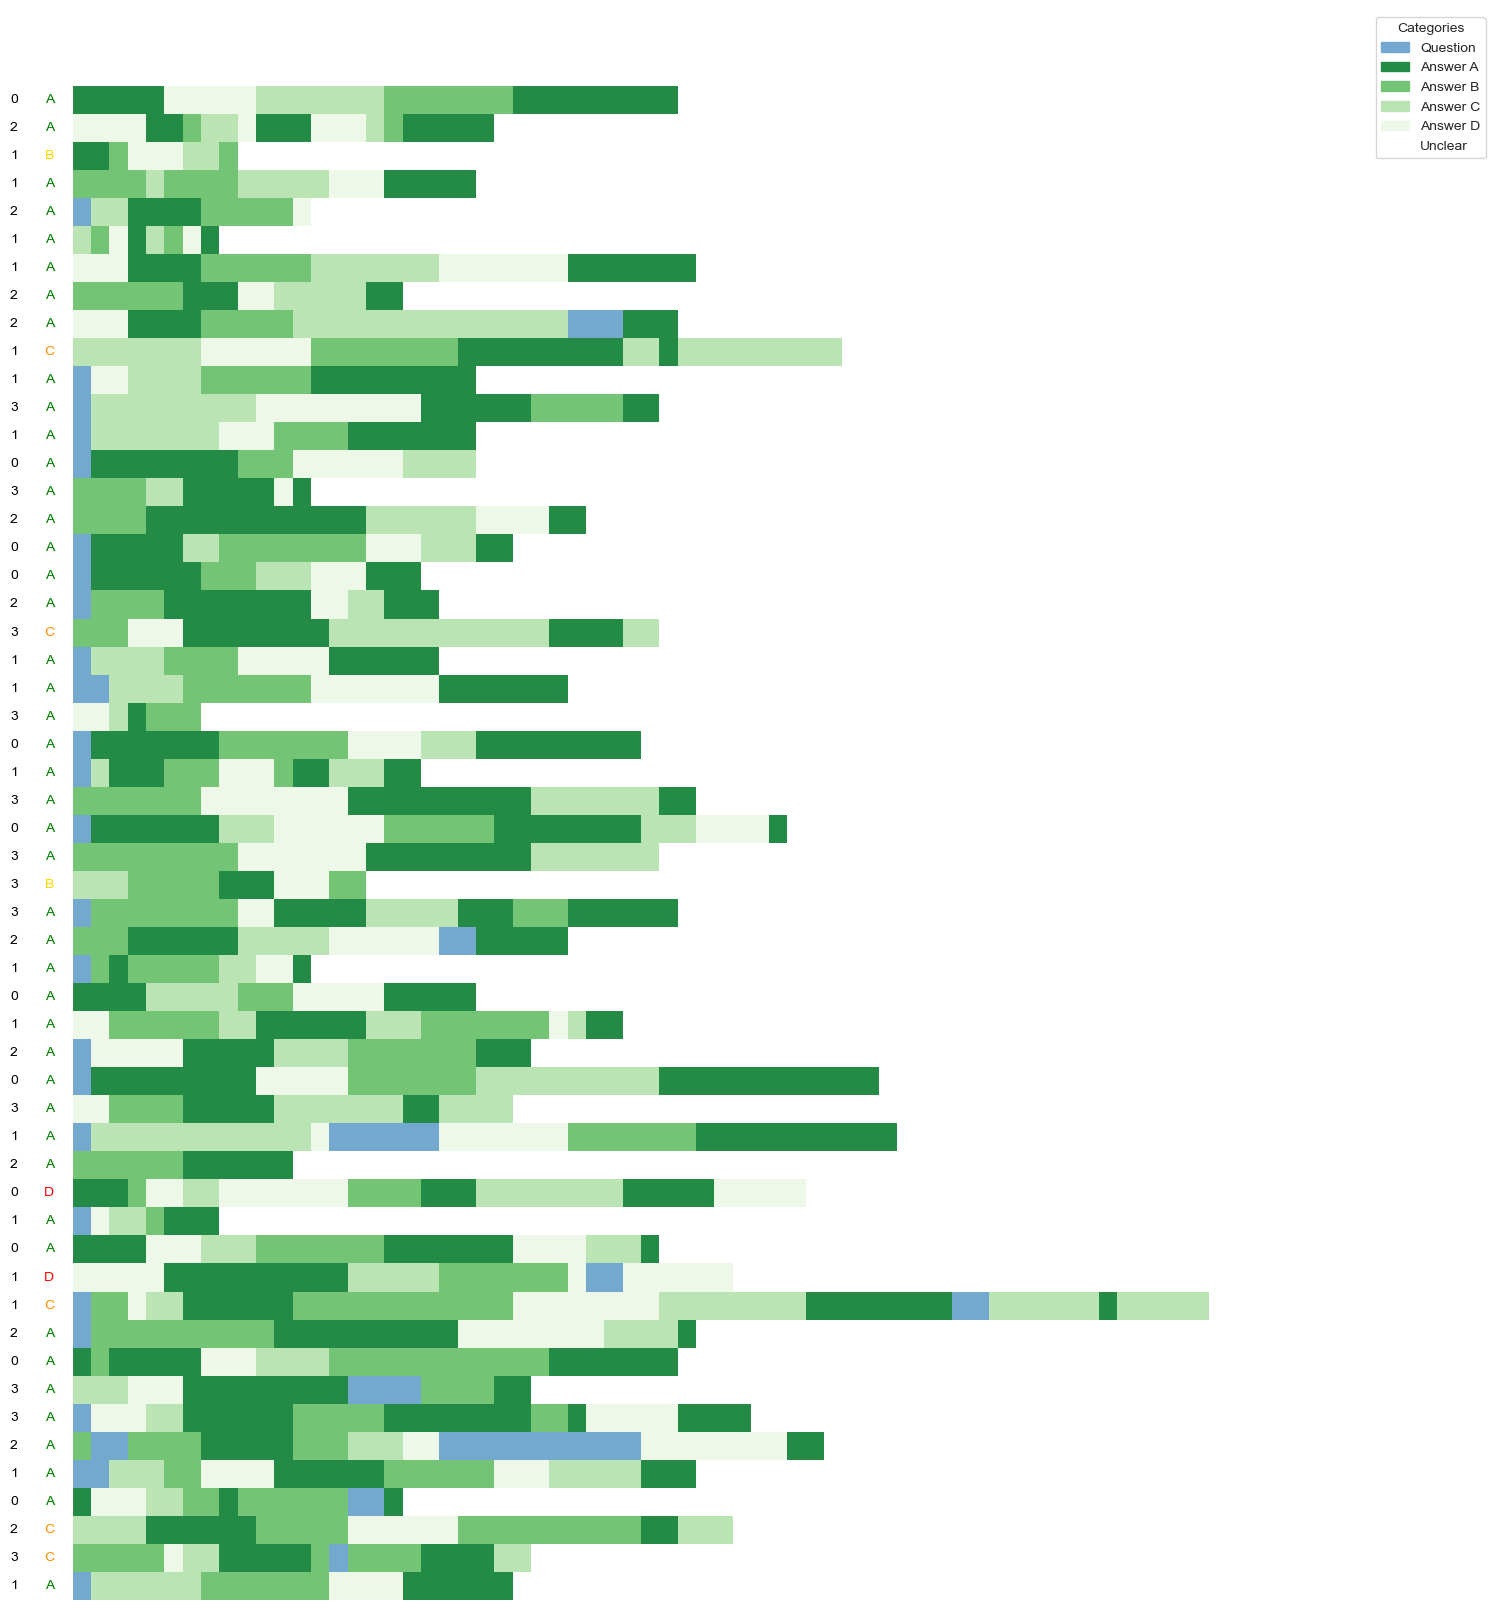

In [20]:
visualize_by_id(data_rows_h, by_person_or_text='person', fix_by='label', identifier='l52_164')